# <div align="center"> Pemodelan Prediktif Klasifikasi Breast Cancer pada Image Ultrasound Menggunakan Metode Support Vector Machine (SVM) </div>

Group 5:
* Almira Zahra Aurelia – 00000080298
* Darren Irawan Djong – 00000081041
* Kayla Abigail Gunawan – 00000081824
* Sabrina Fajrul Ula Usman – 00000083124

# Breast Ultrasound Images Dataset for SVM 

LINK KAGGLE : https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

# Prepare and Collect Data

In [19]:
import os

data_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/image ml/Dataset_BUSI_with_GT"
benign_path = os.path.join(data_path, "benign")
malignant_path = os.path.join(data_path, "malignant")
normal_path = os.path.join(data_path, "normal")

In [20]:
import cv2
from tqdm import tqdm

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (100, 100))  # Resize the image as needed
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error occurred while processing image {img_path}: {e}")
    return images, labels

In [21]:
benign_images, benign_labels = load_images(benign_path, "benign")
malignant_images, malignant_labels = load_images(malignant_path, "malignant")
normal_images, normal_labels = load_images(normal_path, "normal")

  2%|▏         | 10/462 [00:00<00:04, 97.46it/s]

  6%|▌         | 22/400 [00:00<00:03, 103.36it/s]

100%|██████████| 400/400 [00:03<00:00, 101.74it/s]


In [22]:
all_images = benign_images + malignant_images + normal_images
all_labels = benign_labels + malignant_labels + normal_labels

In [23]:
import numpy as np

X = np.array(all_images)
y = np.array(all_labels)

In [24]:
np.unique(y)

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [25]:
import pandas as pd

pd.Series(y).value_counts()

malignant    461
benign       437
normal       399
Name: count, dtype: int64

In [26]:
X.shape

(1297, 100, 100, 3)

In [27]:
y.shape

(1297,)

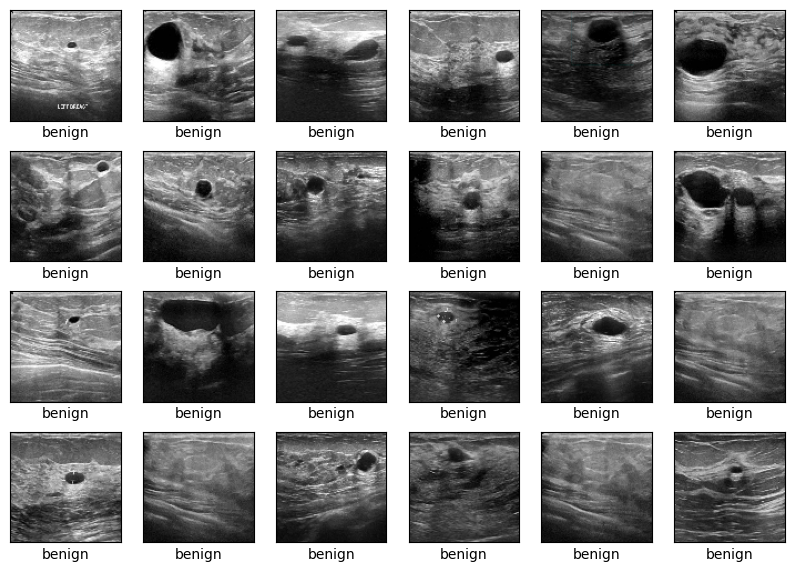

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6, figsize=(10, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=y[i])

In [29]:
X = X.reshape(len(X), -1)
y = y.reshape(len(X), -1)

X.shape, y.shape

((1297, 30000), (1297, 1))

# Split Data

In [30]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=10, 
                                                test_size=.20)

In [31]:
Xtrain.shape, Xtest.shape

((1037, 30000), (260, 30000))

# Feature Scalling

In [32]:
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

255 0
255 0


In [33]:
Xtrain = Xtrain/255
Xtest = Xtest/255
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

1.0 0.0
1.0 0.0


# Feature Selection

In [34]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

# Train Model

In [35]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 9min 13s
Wall time: 2min 40s
{'svc__C': 50, 'svc__gamma': 0.005}


In [36]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

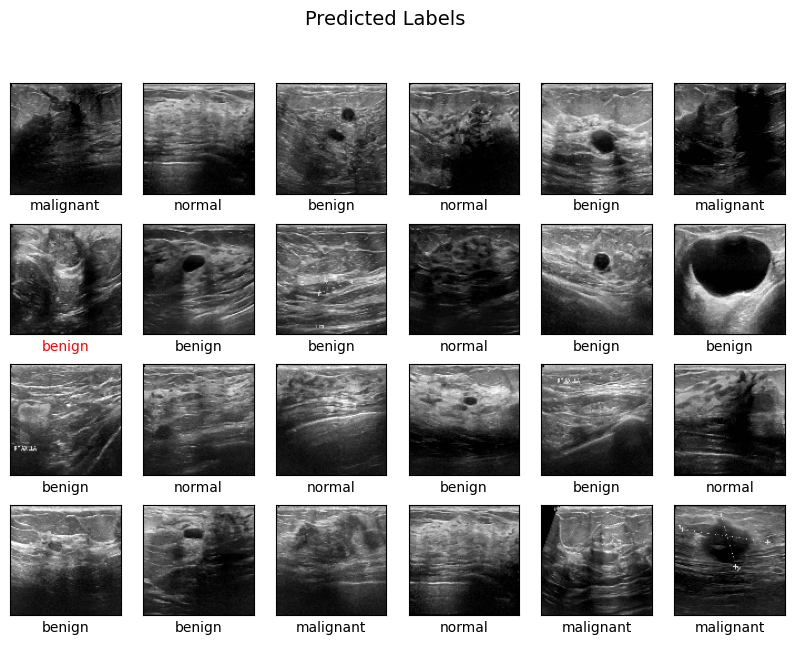

In [37]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [38]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 1037
Jumlah sampel data pengujian: 260


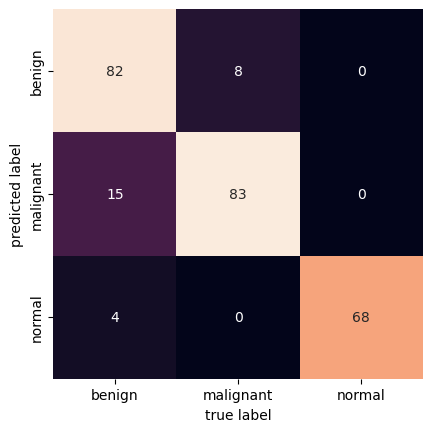

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('true label')
plt.ylabel('predicted label');

# Evaluation

In [40]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9971070395371263
Testing Score: 0.8961538461538462


# K-FOLD CROSS VALIDATION

In [42]:
from sklearn.model_selection import cross_val_score
k_fold_acc = cross_val_score(model, Xtrain, ytrain, cv=10)
k_fold_mean = k_fold_acc.mean()

In [43]:
k_fold_acc

array([0.88461538, 0.88461538, 0.91346154, 0.85576923, 0.91346154,
       0.93269231, 0.90384615, 0.90291262, 0.93203883, 0.88349515])

In [44]:
k_fold_mean

0.9006908140403287

# NEW QUERY

In [ ]:
import joblib

# Menyimpan model ke dalam file
joblib.dump(model, 'UltraSound_SVM.model')

In [48]:
=# Memuat model dari file
model = joblib.load('UltraSound_SVM.model')
model

Pipeline(steps=[('pca', PCA(n_components=150, whiten=True)),
                ('svc', SVC(C=50, class_weight='balanced', gamma=0.005))])

In [69]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [70]:
# Direktori yang berisi new benign images
new_benign_images = 'C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/DATA FOR NEW QUERY/Benign'

# Fungsi untuk memproses dan memprediksi new benign images
def predict_images_in_directory(model, directory):
    predictions = []
    images = []
    image_paths = []

    for filename in os.listdir(directory):
        # Membuat path lengkap ke file gambar
        file_path = os.path.join(directory, filename)

        # Membaca gambar baru
        image = cv2.imread(file_path)

        # Pengecekan apakah gambar berhasil dibaca
        if image is None:
            print(f"Error: Gagal membaca gambar dari {file_path}")
            continue

        # Resize gambar sesuai dengan ukuran yang digunakan saat melatih model
        image_resized = cv2.resize(image, (100, 100))

        # Reshape gambar ke format yang sesuai
        image_reshaped = image_resized.reshape(1, -1)

        # Normalisasi data jika diperlukan
        image_normalized = image_reshaped / 255.0

        # Melakukan prediksi menggunakan model yang dimuat
        prediction = model.predict(image_normalized)

        # Menyimpan hasil prediksi dan gambar
        predictions.append(prediction[0])
        images.append(image_resized)
        image_paths.append(file_path)

    return images, predictions, image_paths

# Melakukan prediksi untuk semua gambar dalam direktori
images, predictions, image_paths = predict_images_in_directory(model, new_benign_images)

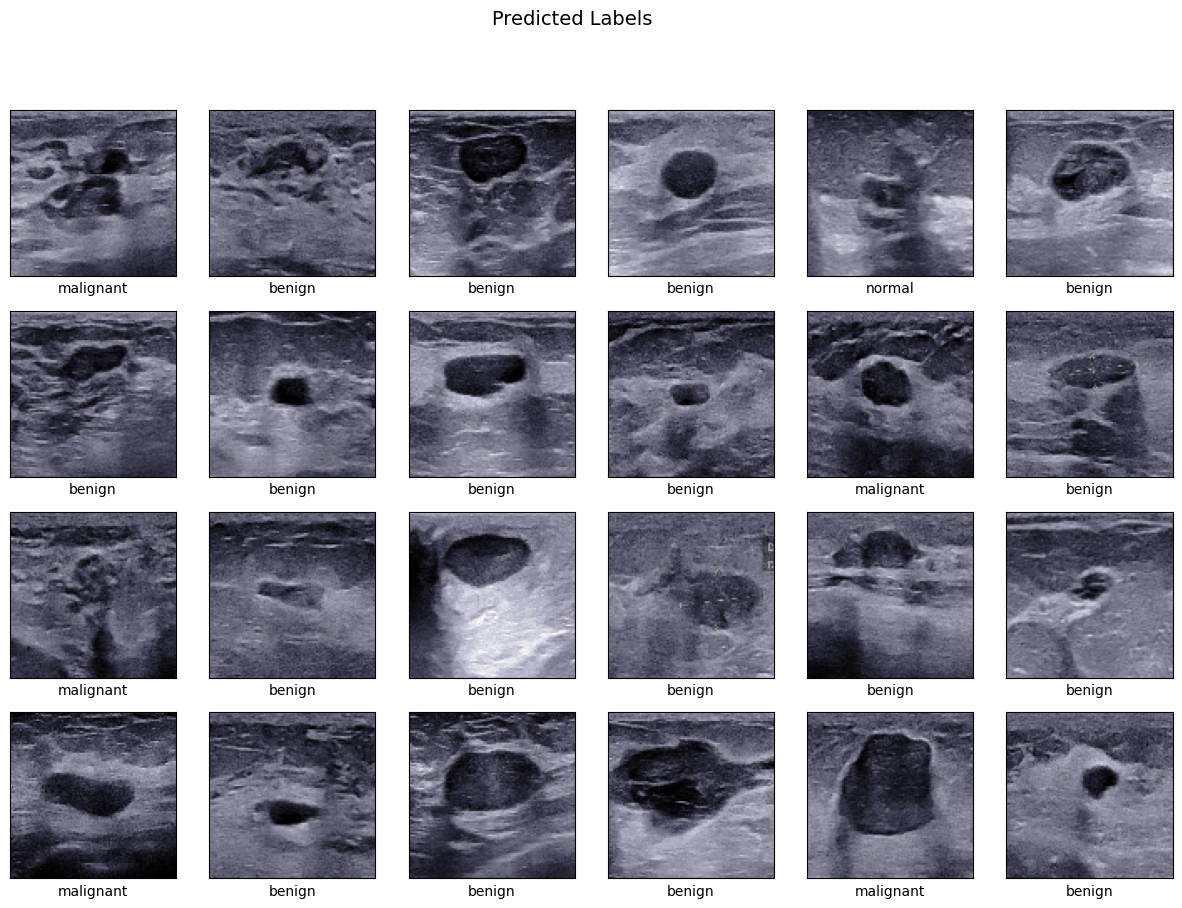

In [71]:
# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(15, 10))

for i, axi in enumerate(ax.flat):
    if i < len(images):
        axi.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(f'{predictions[i]}', color='black')
    else:
        axi.axis('off')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [72]:
# Direktori yang berisi new malignant images
new_malignant_images = 'C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/DATA FOR NEW QUERY/Malignant'

# Fungsi untuk memproses dan memprediksi new malignant images
def predict_images_in_directory(model, directory):
    predictions = []
    images = []
    image_paths = []

    for filename in os.listdir(directory):
        # Membuat path lengkap ke file gambar
        file_path = os.path.join(directory, filename)

        # Membaca gambar baru
        image = cv2.imread(file_path)

        # Pengecekan apakah gambar berhasil dibaca
        if image is None:
            print(f"Error: Gagal membaca gambar dari {file_path}")
            continue

        # Resize gambar sesuai dengan ukuran yang digunakan saat melatih model
        image_resized = cv2.resize(image, (100, 100))

        # Reshape gambar ke format yang sesuai
        image_reshaped = image_resized.reshape(1, -1)

        # Normalisasi data jika diperlukan
        image_normalized = image_reshaped / 255.0

        # Melakukan prediksi menggunakan model yang dimuat
        prediction = model.predict(image_normalized)

        # Menyimpan hasil prediksi dan gambar
        predictions.append(prediction[0])
        images.append(image_resized)
        image_paths.append(file_path)

    return images, predictions, image_paths

# Melakukan prediksi untuk semua gambar dalam direktori
images, predictions, image_paths = predict_images_in_directory(model, new_malignant_images)

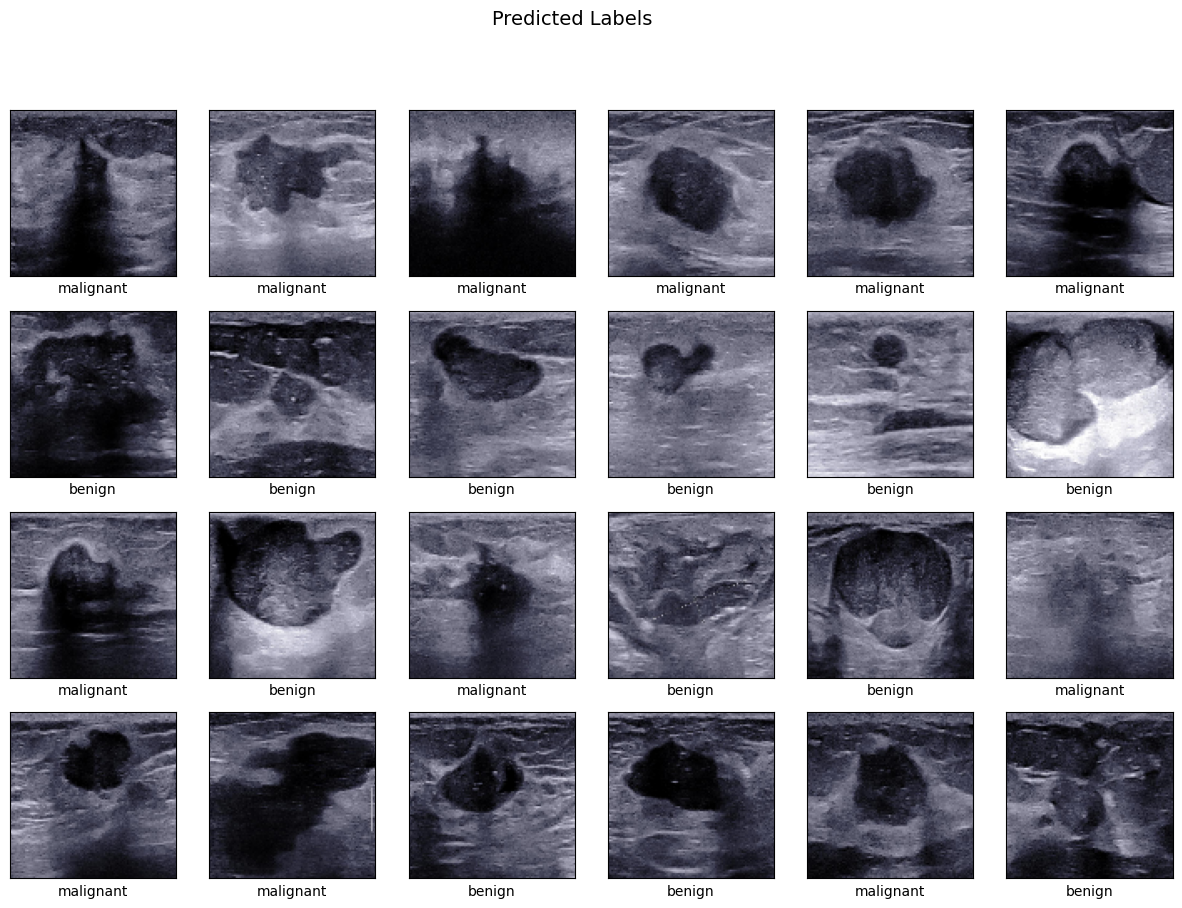

In [73]:
# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(15, 10))

for i, axi in enumerate(ax.flat):
    if i < len(images):
        axi.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(f'{predictions[i]}', color='black')
    else:
        axi.axis('off')

fig.suptitle('Predicted Labels', size=14)
plt.show()

---

### TRAIN 2
### Linear

In [21]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svc)

In [22]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 37s
Wall time: 3min 7s
{'svc__C': 10, 'svc__gamma': 0.0001}


In [23]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

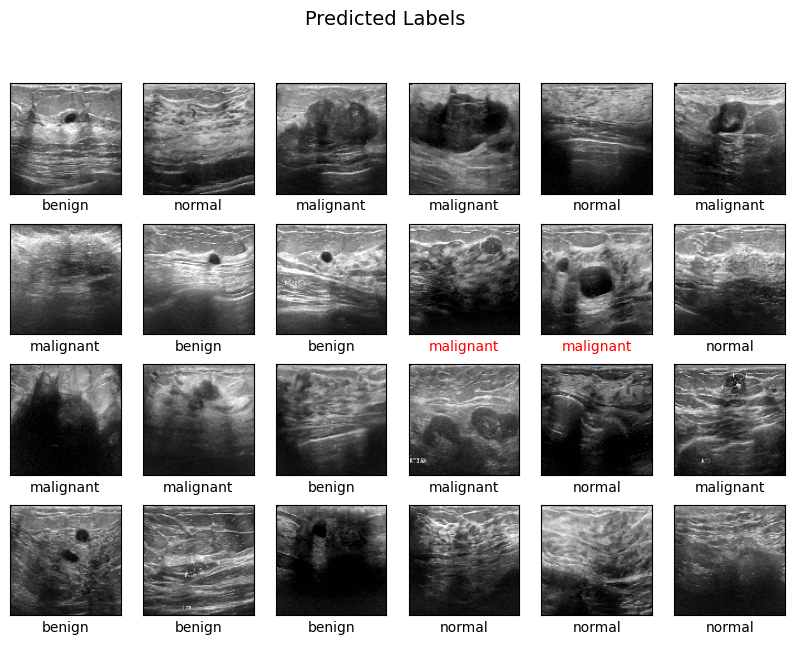

In [24]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [25]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [26]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.76      0.72      0.74        80
   malignant       0.81      0.78      0.79        89
      normal       0.90      1.00      0.95        71

    accuracy                           0.82       240
   macro avg       0.82      0.83      0.83       240
weighted avg       0.82      0.82      0.82       240



In [27]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9791013584117032
Testing Score: 0.825


### TRAIN 3 
### SIGMOID

In [28]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='sigmoid', class_weight='balanced')
model = make_pipeline(pca, svc)

In [29]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 23s
Wall time: 2min 39s
{'svc__C': 50, 'svc__gamma': 0.0005}


In [30]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

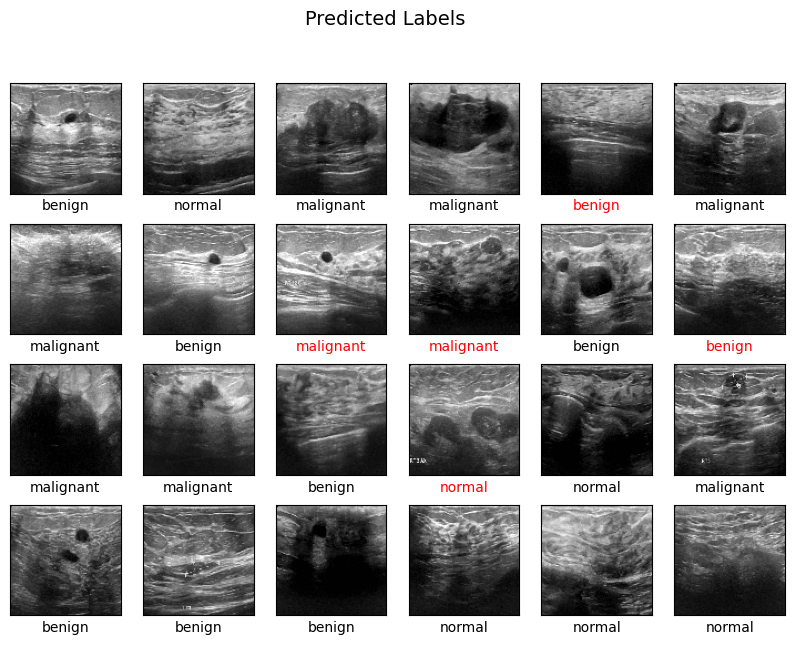

In [31]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [32]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [33]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.56      0.60      0.58        80
   malignant       0.72      0.73      0.73        89
      normal       0.83      0.75      0.79        71

    accuracy                           0.69       240
   macro avg       0.70      0.69      0.70       240
weighted avg       0.70      0.69      0.69       240



In [34]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.8746081504702194
Testing Score: 0.6916666666666667


### TRAIN 3 
### SIGMOID

In [35]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='sigmoid', class_weight='balanced')
model = make_pipeline(pca, svc)

In [36]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 22s
Wall time: 2min 41s
{'svc__C': 50, 'svc__gamma': 0.0005}


In [37]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

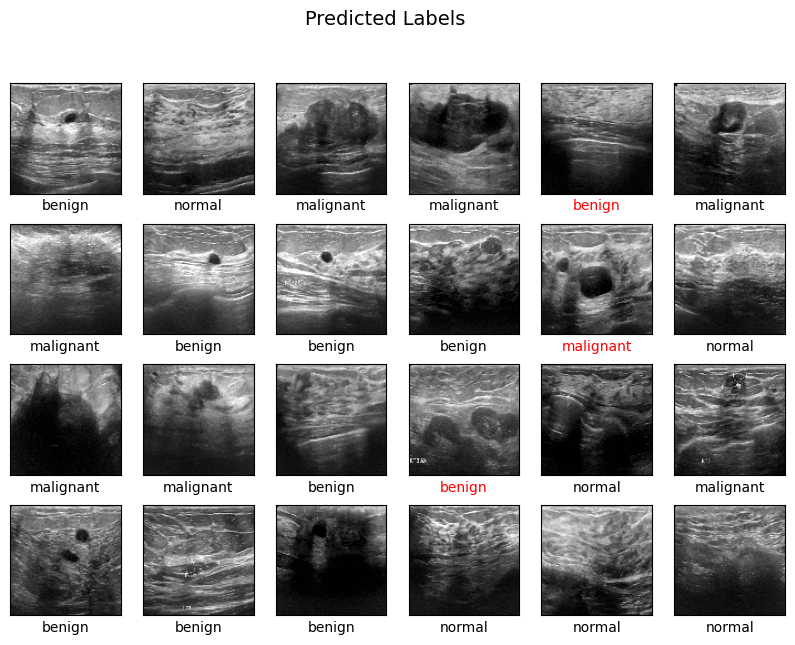

In [38]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [39]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [40]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.60      0.61      0.60        80
   malignant       0.74      0.74      0.74        89
      normal       0.83      0.80      0.81        71

    accuracy                           0.72       240
   macro avg       0.72      0.72      0.72       240
weighted avg       0.72      0.72      0.72       240



In [41]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.8787878787878788
Testing Score: 0.7166666666666667


In [42]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

# Membuat model dengan PCA dan SVC
def create_pipeline(kernel='rbf'):
    pca = RandomizedPCA(n_components=150, whiten=True)
    svc = SVC(kernel=kernel, class_weight='balanced')
    model = make_pipeline(pca, svc)
    return model

# Mengatur parameter grid untuk setiap kernel
param_grids = {
    'rbf': {'svc__C': [1, 5, 10, 50],
            'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
    'sigmoid': {'svc__C': [1, 5, 10, 50],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005],
                'svc__coef0': [0.0, 0.1, 0.5, 1.0]},
    'linear': {'svc__C': [1, 5, 10, 50]}
}

# Membuat dan menjalankan GridSearchCV untuk setiap kernel
results = {}
for kernel, param_grid in param_grids.items():
    model = create_pipeline(kernel)
    grid = GridSearchCV(model, param_grid)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid.fit(Xtrain, ytrain)
    results[kernel] = grid

# Menampilkan hasil terbaik untuk setiap kernel
for kernel, grid in results.items():
    print(f"Best parameters for {kernel} kernel: {grid.best_params_}")


Best parameters for rbf kernel: {'svc__C': 5, 'svc__gamma': 0.005}
Best parameters for sigmoid kernel: {'svc__C': 50, 'svc__coef0': 0.1, 'svc__gamma': 0.0005}
Best parameters for linear kernel: {'svc__C': 50}


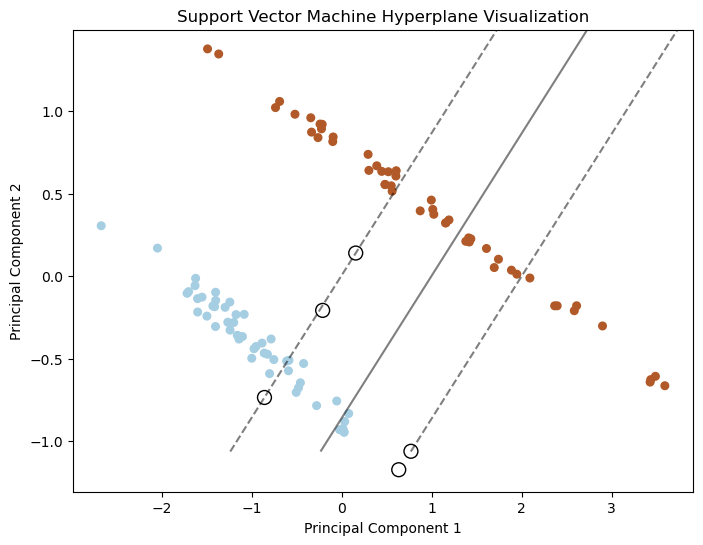

In [43]:
#r
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, 
                            n_informative=2, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane
def plot_hyperplane(X, y, clf):
    plt.figure(figsize=(8, 6))

    # Mengurangi dimensi data ke 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot data point
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Membuat grid untuk menggambar hyperplane
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Visualisasi hyperplane dan margin
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # Menandai support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Support Vector Machine Hyperplane Visualization')
    plt.show()

# Memvisualisasikan hyperplane
plot_hyperplane(X, y, svm)


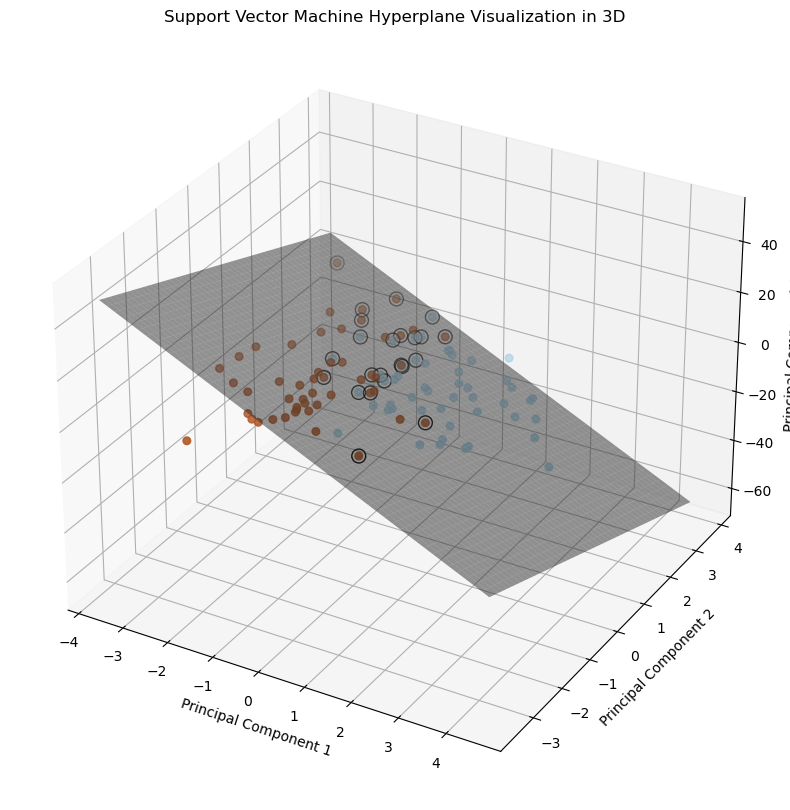

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=3, n_classes=2, n_clusters_per_class=1, 
                            n_informative=3, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane dalam 3 dimensi
def plot_hyperplane_3d(X, y, clf):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    z = (-clf.intercept_[0] - clf.coef_[0][0] * xx - clf.coef_[0][1] * yy) / clf.coef_[0][2]
    ax.plot_surface(xx, yy, z, color='gray', alpha=0.5)

    # Menandai support vectors
    support_vectors = pca.transform(clf.support_vectors_)
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1], support_vectors[:, 2],
               s=100, linewidth=1, facecolors='none', edgecolors='k')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('Support Vector Machine Hyperplane Visualization in 3D')
    plt.show()

# Memvisualisasikan hyperplane dalam 3 dimensi
plot_hyperplane_3d(X, y, svm)


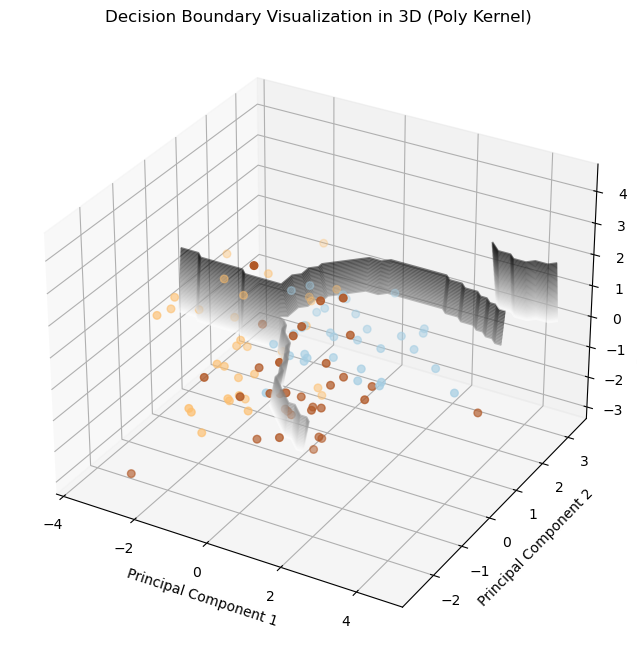

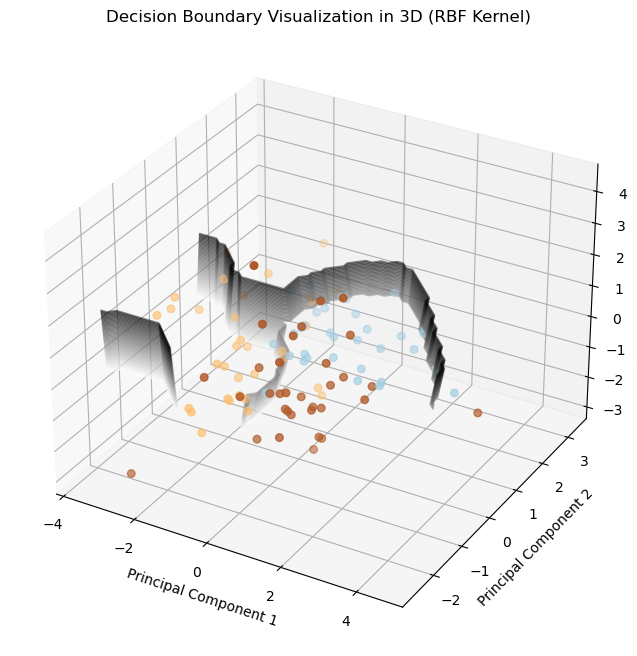

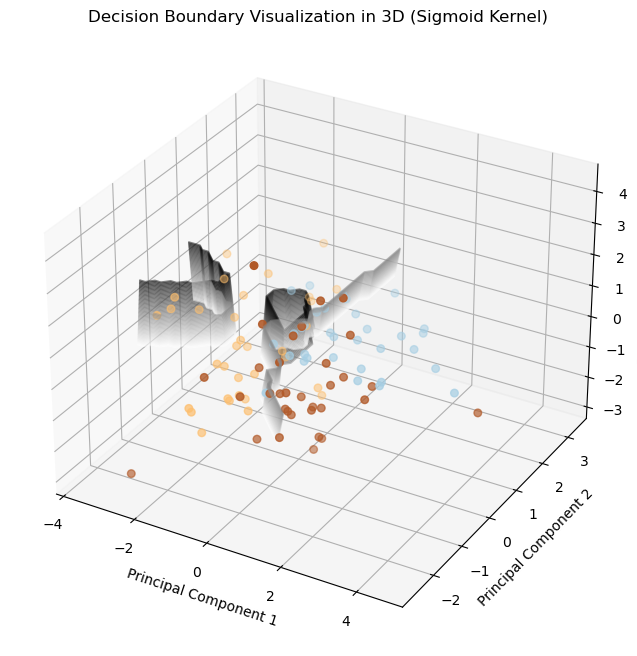

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=3, n_classes=3, n_clusters_per_class=1, 
                            n_informative=3, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM dengan kernel poly
svm_poly = SVC(kernel='poly', degree=3, coef0=1)
svm_poly.fit(X, y)

# Membuat model SVM dengan kernel rbf
svm_rbf = SVC(kernel='rbf', gamma='auto')
svm_rbf.fit(X, y)

# Membuat model SVM dengan kernel sigmoid
svm_sigmoid = SVC(kernel='sigmoid', coef0=1)
svm_sigmoid.fit(X, y)

# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=30)

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    plt.show()

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


### TRAIN 4 POLY

In [47]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='poly', class_weight='balanced')
model = make_pipeline(pca, svc)

In [48]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 40s
Wall time: 2min 36s
{'svc__C': 50, 'svc__gamma': 0.005}


In [49]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

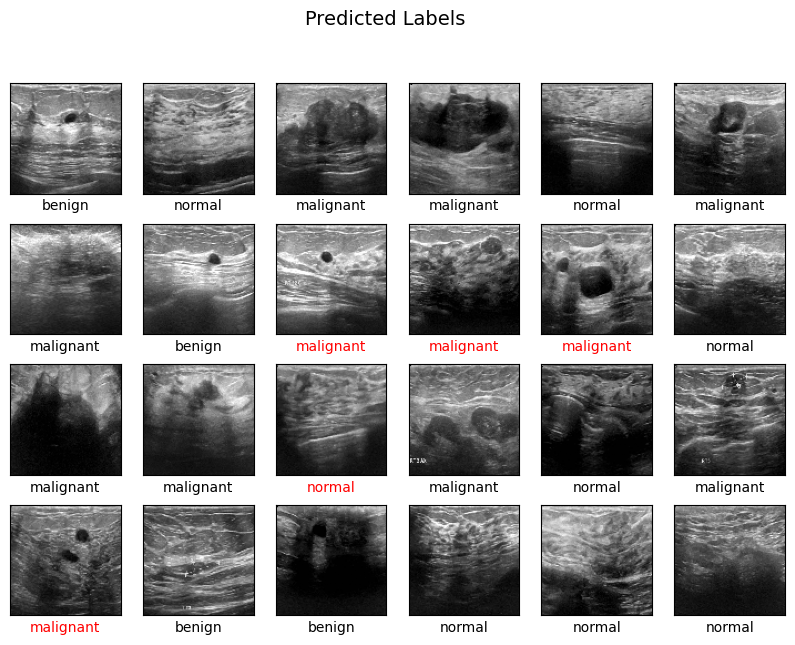

In [50]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [51]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [52]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.97      0.42      0.59        80
   malignant       0.66      0.99      0.79        89
      normal       0.99      1.00      0.99        71

    accuracy                           0.80       240
   macro avg       0.87      0.80      0.79       240
weighted avg       0.86      0.80      0.78       240



In [53]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9968652037617555
Testing Score: 0.8041666666666667


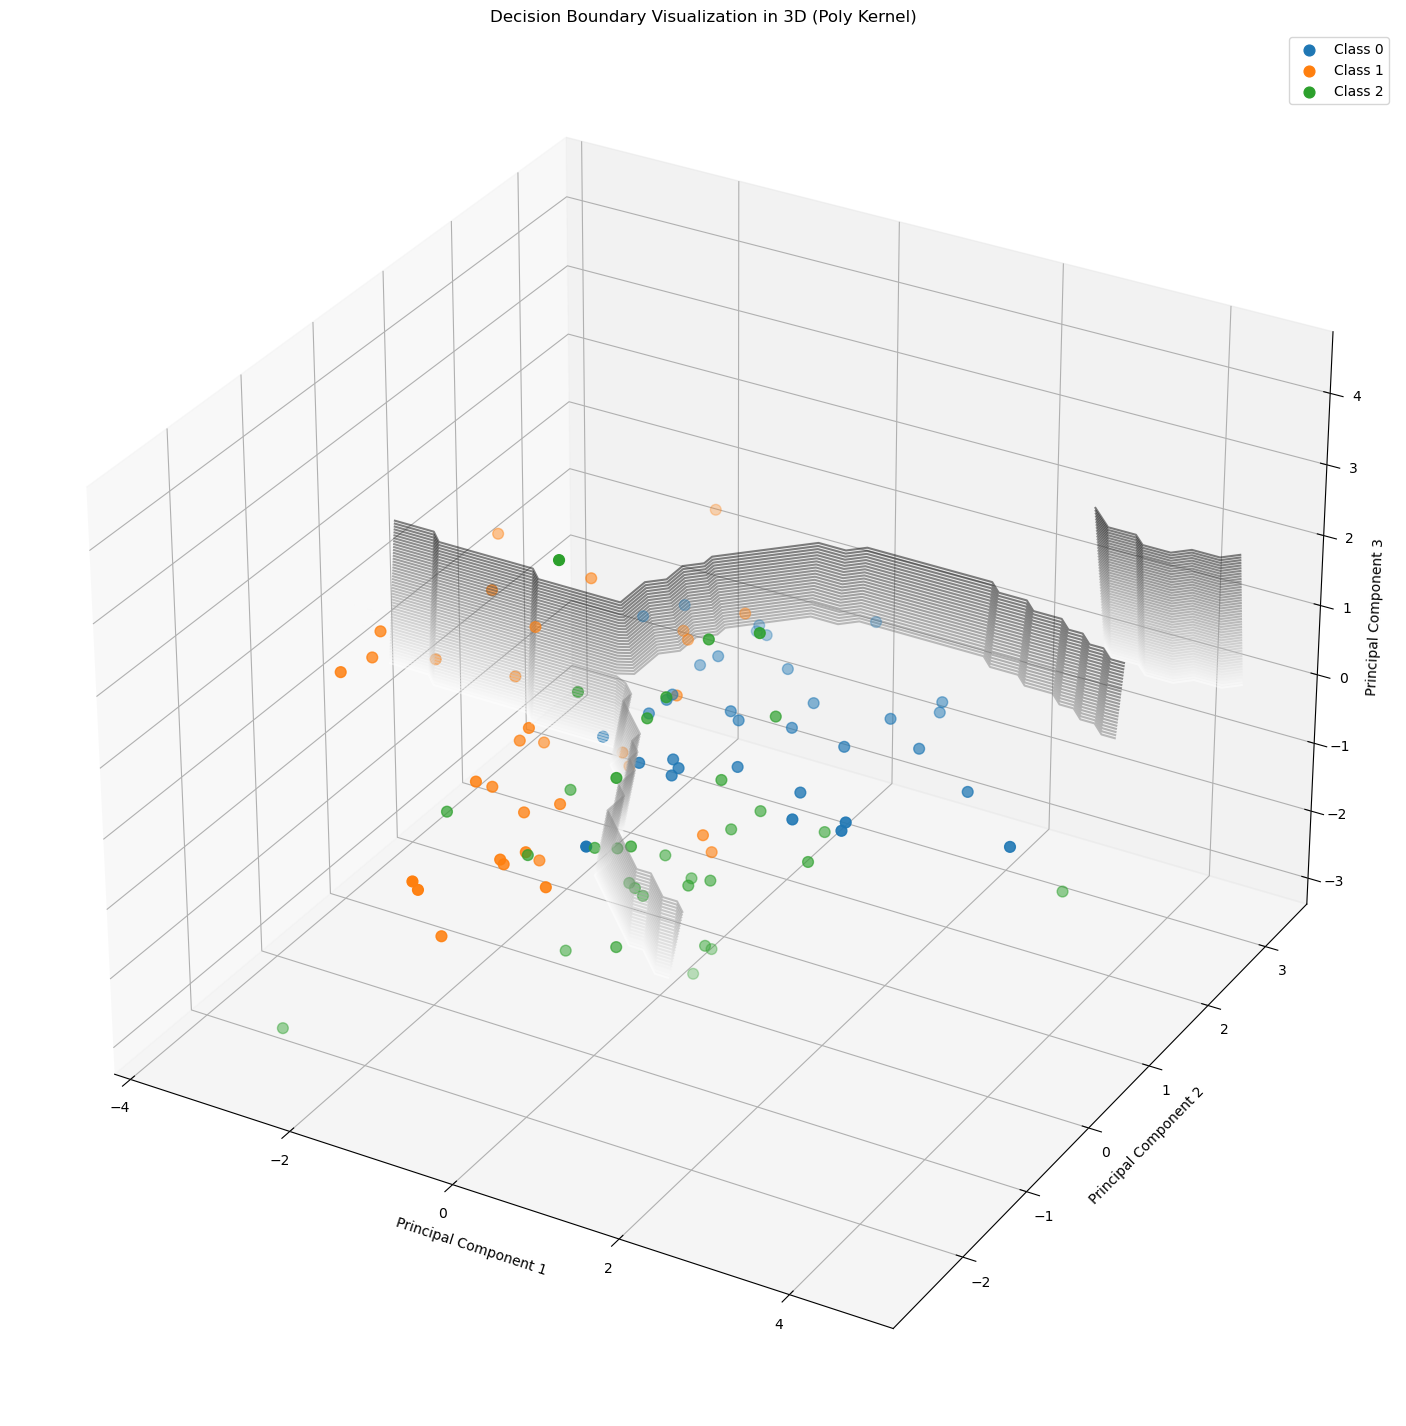

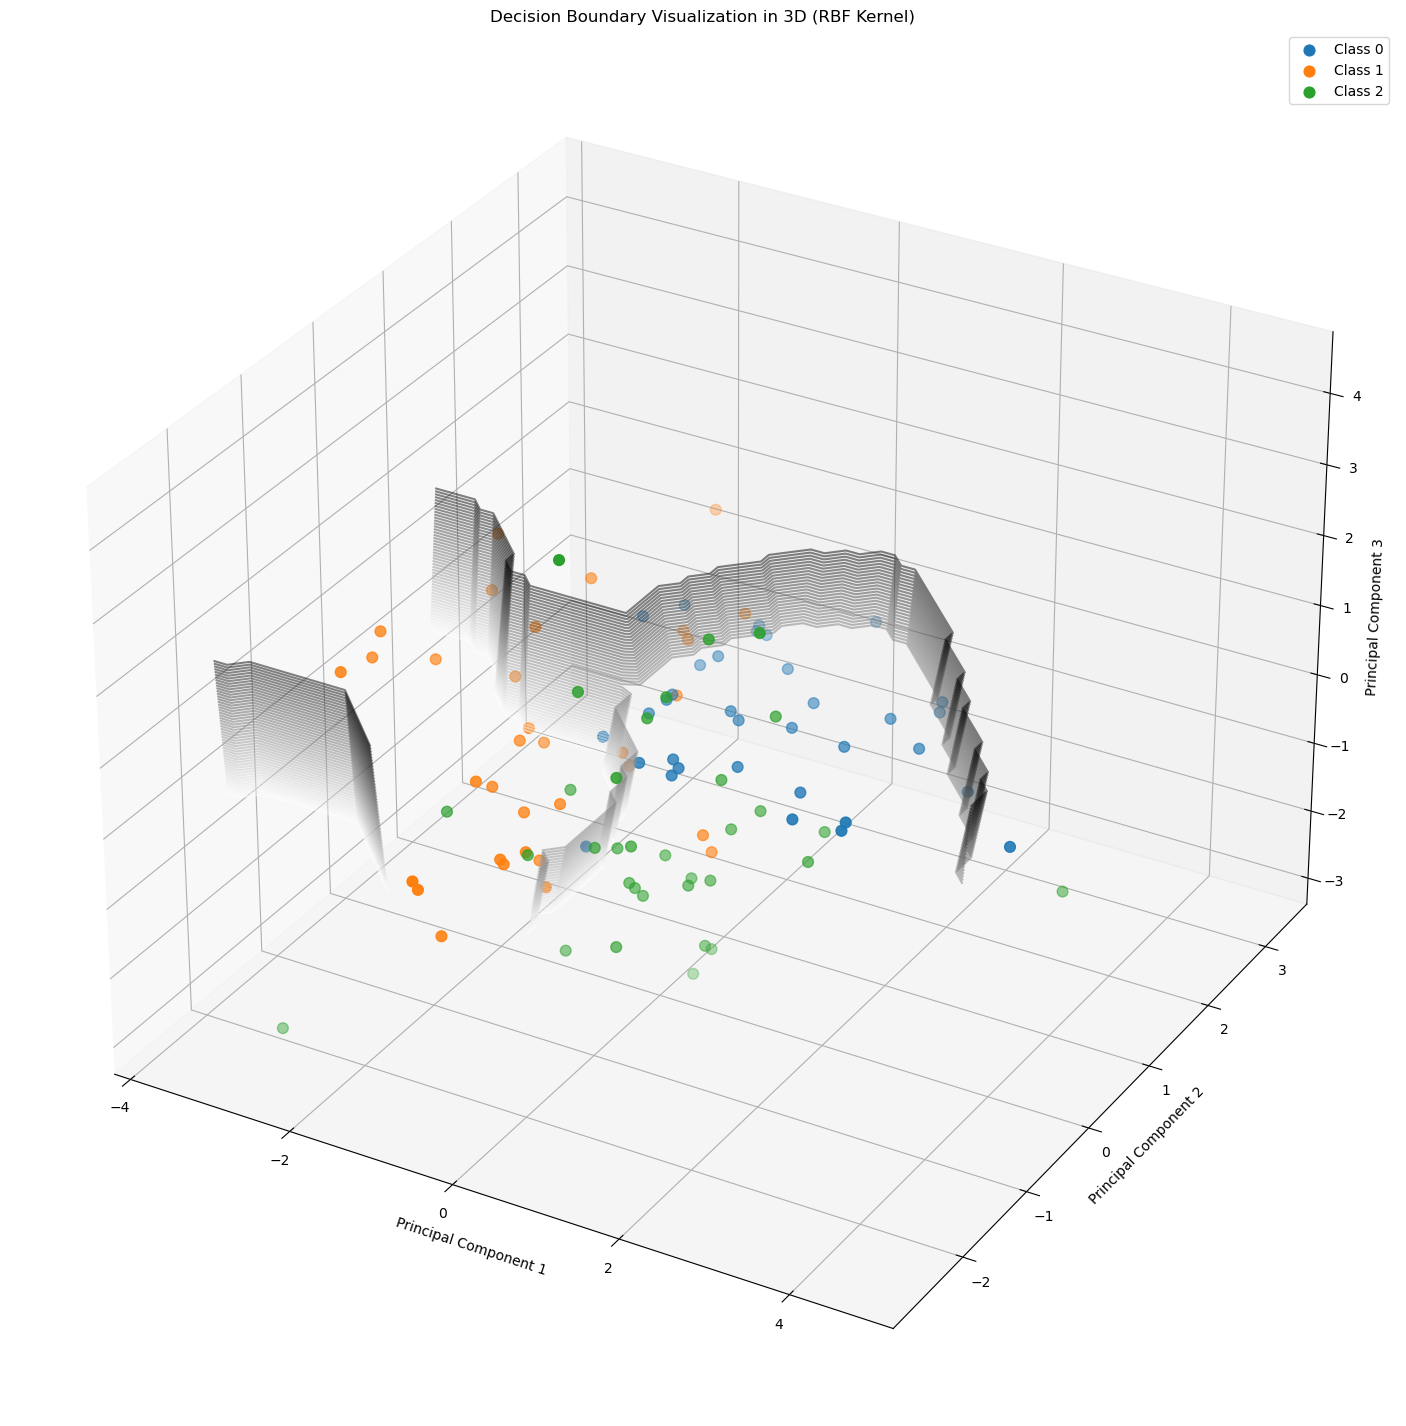

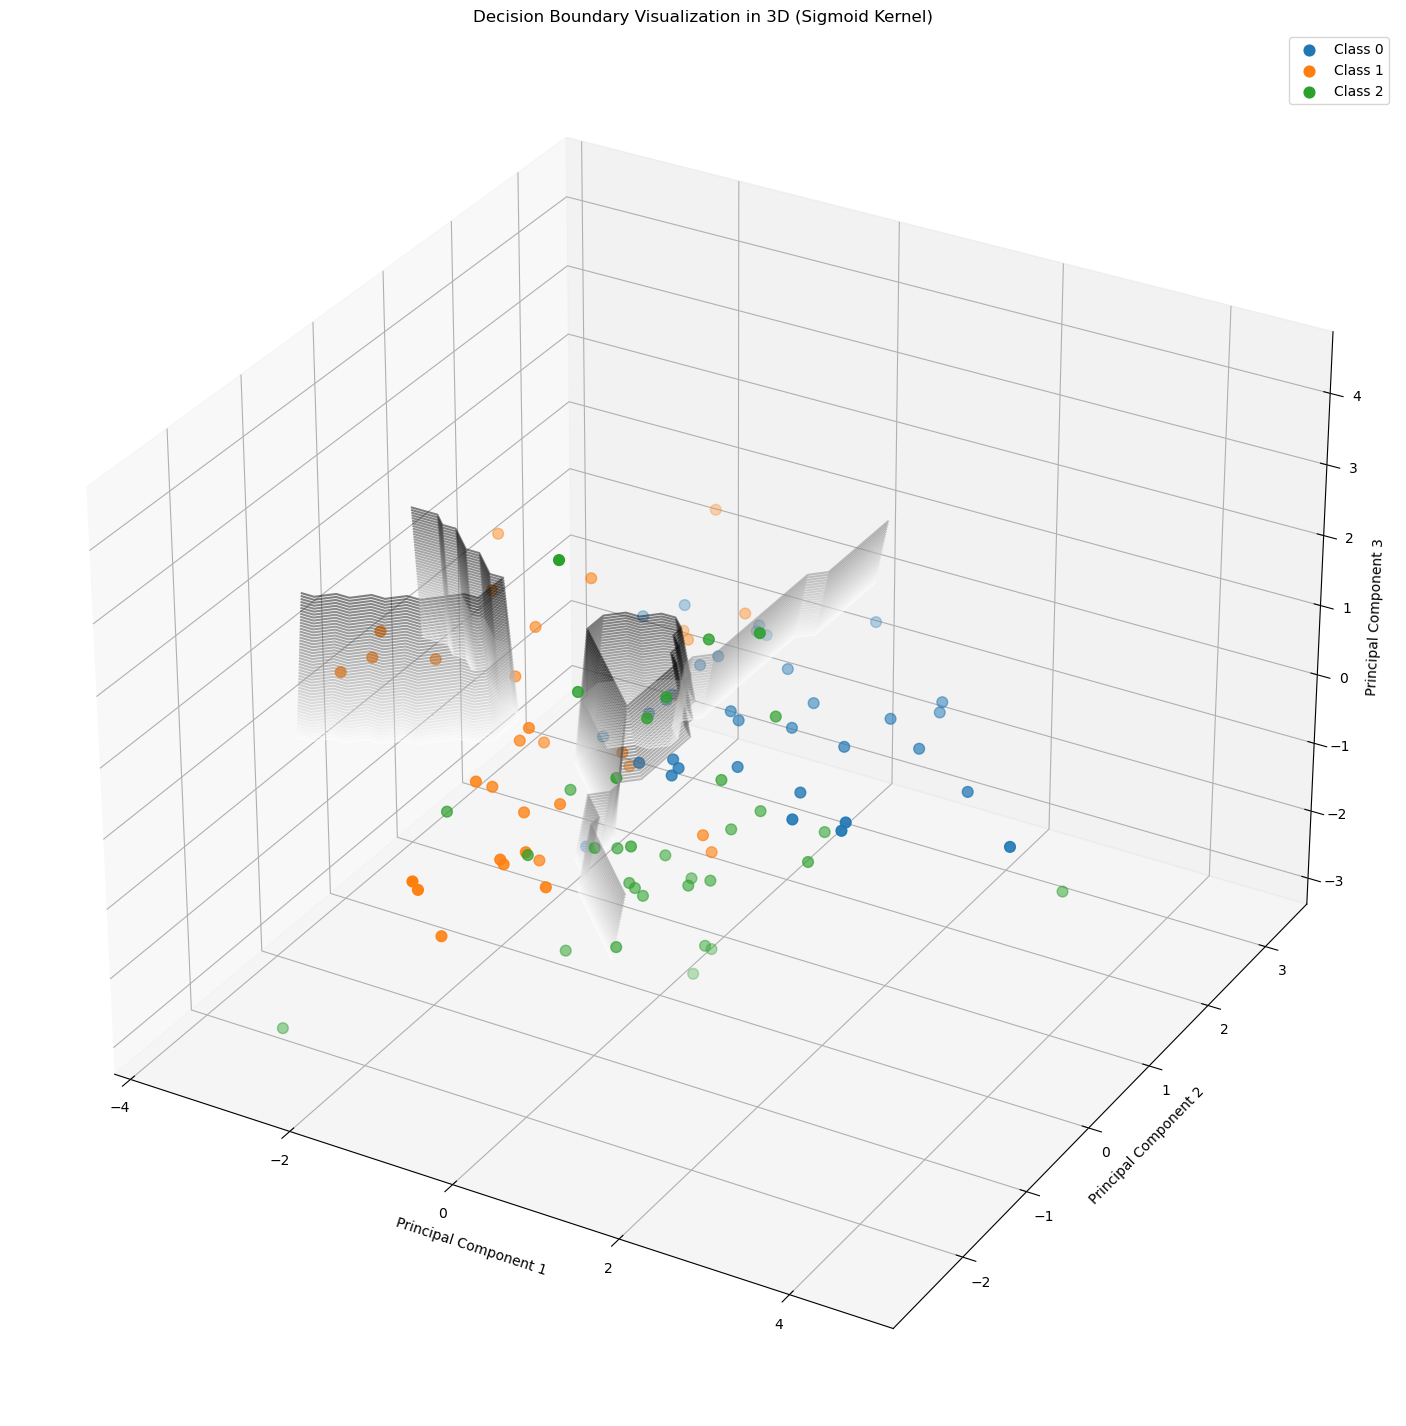

In [54]:
# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi dengan titik data yang jelas
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    for i in range(3):
        ax.scatter(X_pca[y==i, 0], X_pca[y==i, 1], X_pca[y==i, 2], cmap=plt.cm.Paired, s=60, label=f'Class {i}')

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


In [55]:
# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi dengan titik data yang jelas
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=60)

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    ax.legend(['Class 0', 'Class 1', 'Class 2'])  # Add legend
    plt.show()


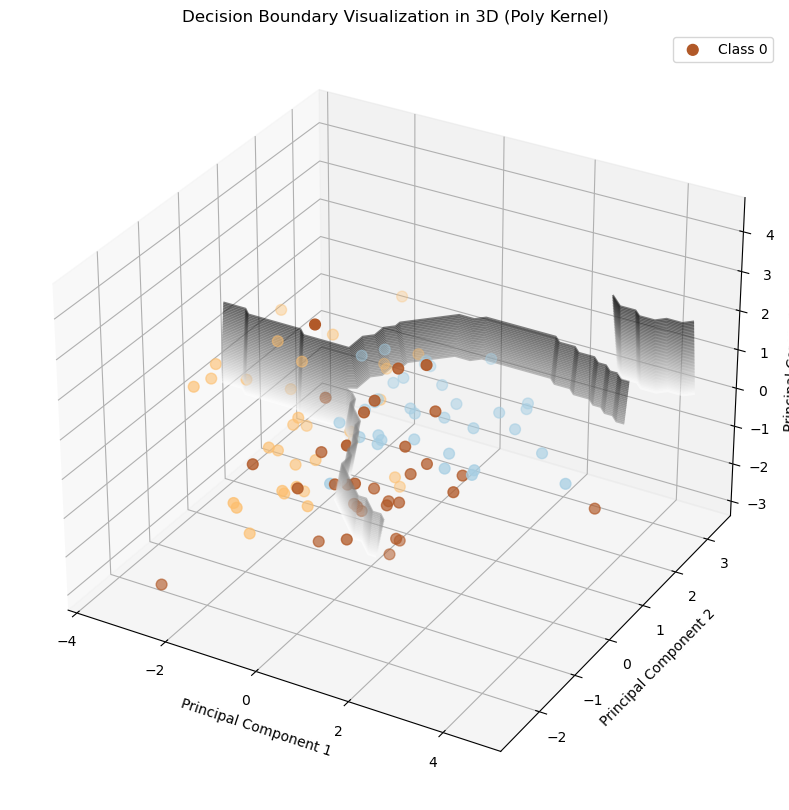

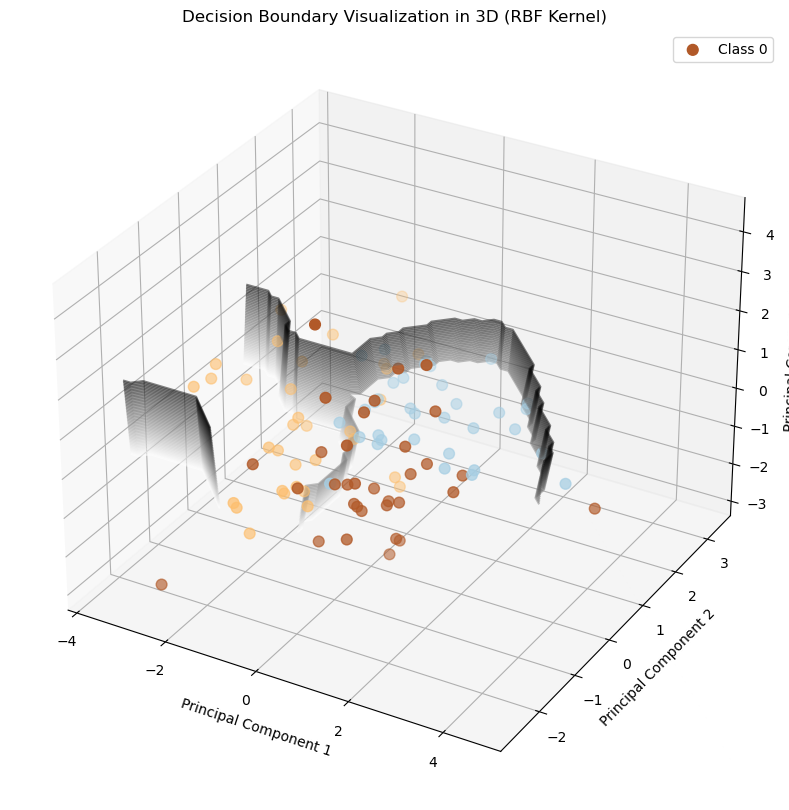

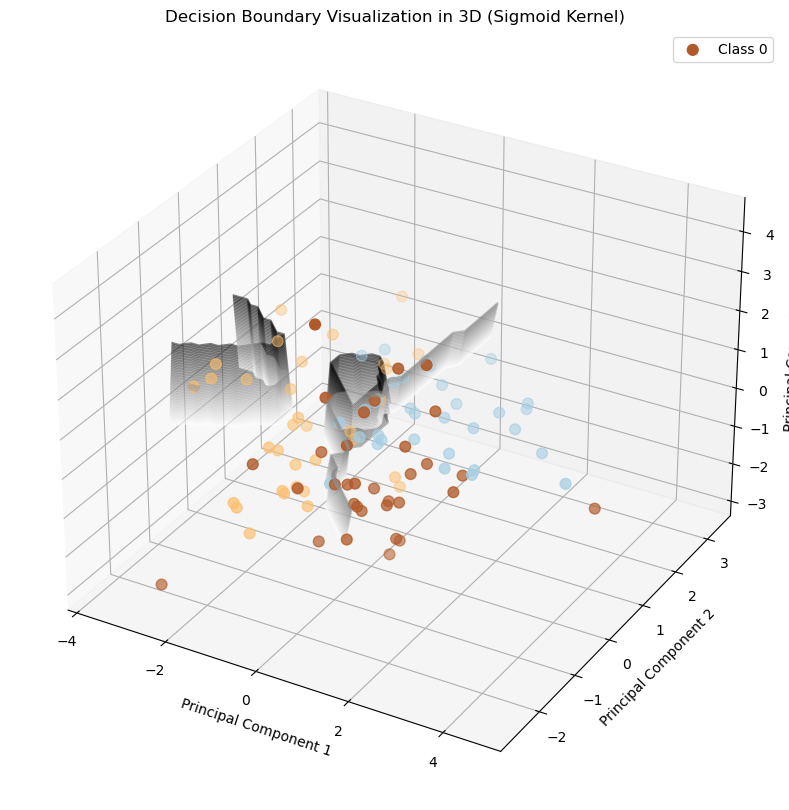

In [56]:
# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


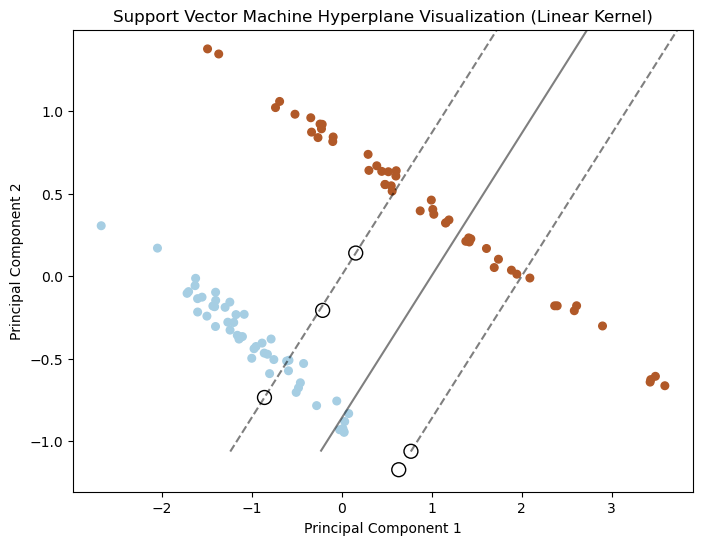

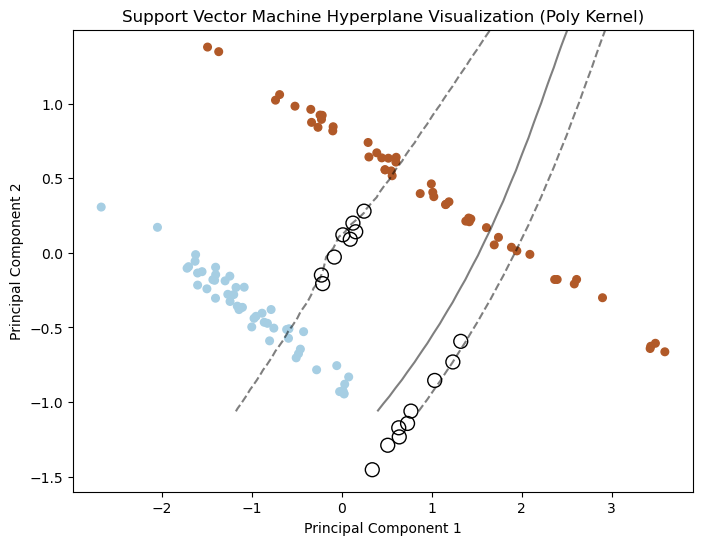

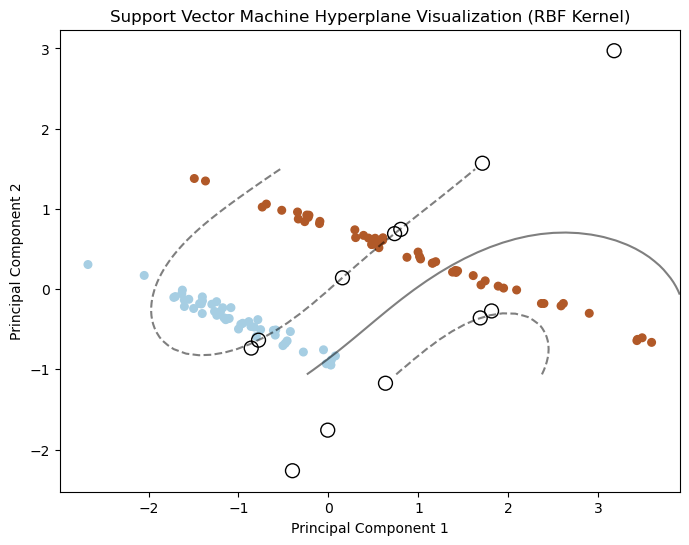

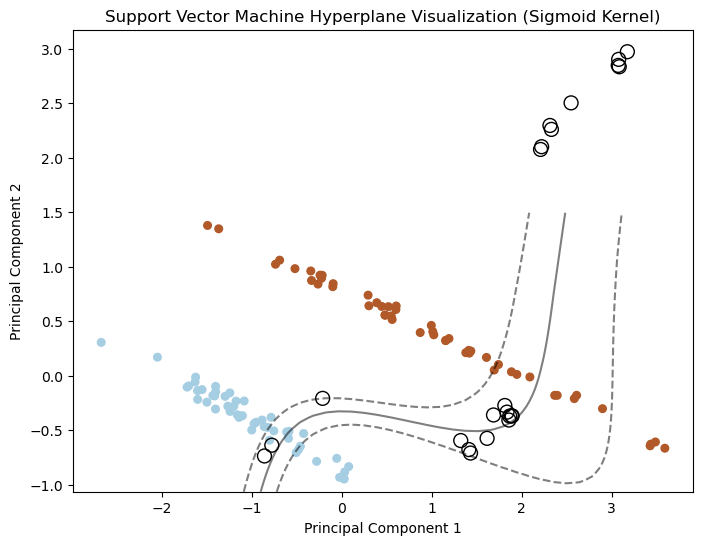

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, 
                            n_informative=2, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM dengan kernel linear
svm_linear = SVC(kernel='linear')
svm_linear.fit(X, y)

# Membuat model SVM dengan kernel poly
svm_poly = SVC(kernel='poly', degree=3)
svm_poly.fit(X, y)

# Membuat model SVM dengan kernel rbf
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X, y)

# Membuat model SVM dengan kernel sigmoid
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane
def plot_hyperplane(X, y, clf, title):
    plt.figure(figsize=(8, 6))

    # Mengurangi dimensi data ke 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot data point
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Membuat grid untuk menggambar hyperplane
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Visualisasi hyperplane dan margin
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # Menandai support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.show()

# Memvisualisasikan hyperplane untuk kernel linear
plot_hyperplane(X, y, svm_linear, 'Support Vector Machine Hyperplane Visualization (Linear Kernel)')

# Memvisualisasikan hyperplane untuk kernel poly
plot_hyperplane(X, y, svm_poly, 'Support Vector Machine Hyperplane Visualization (Poly Kernel)')

# Memvisualisasikan hyperplane untuk kernel rbf
plot_hyperplane(X, y, svm_rbf, 'Support Vector Machine Hyperplane Visualization (RBF Kernel)')

# Memvisualisasikan hyperplane untuk kernel sigmoid
plot_hyperplane(X, y, svm_sigmoid, 'Support Vector Machine Hyperplane Visualization (Sigmoid Kernel)')
